# Electric Consumption Calculator

A model is to predict energy consumption when meter reading got missing or does not come on time form Advanced Metering Infrasture (AMI).  

## Problem Statement
EnergyIP requires continuous data, therefore any missing data must be estimated. When missing data is detected or invalid data recieved, it will be estimated using machine learning model.



## Dataset
The dataset contains the training and test data. Usually metering data contains the customer specific information like premise locaiton, account detial. Due security reason, this exersice excluded customer specific information outside office usage or showcase.

It is located at `/home/contactmasoomraza5231/BootML/Datasets/electric-usage_1/`

# Get the data

In [3]:
import pandas as pd
import os

DATASET_PATH = 'C:/MyData/MySpace/capstone_project/'
def load_dataset_data(dataset_path=DATASET_PATH): 
    csv_path = os.path.join(dataset_path, "historical_meter_data.csv") 
    return pd.read_csv(csv_path)

In [4]:
historical_data = load_dataset_data()
historical_data.head()

,DateTime,lp_value,validation_status,dayType,season
0,2020-12-28 15:00:00,1.818,VAL,Weekday,Winter
1,2022-12-31 06:00:00,0.289,VAL,Weekend,Winter
2,2022-12-31 16:00:00,2.229,VAL,Weekend,Winter
3,2020-12-28 02:00:00,0.109,VAL,Weekday,Winter
4,2020-12-28 12:00:00,0.256,VAL,Weekday,Winter


The relevant attributes in historical_usage_data.csv are : 

lp_value, dayType, season, hour, weekday, month, 



## Let's dop the irrelevant fields from our file


In [5]:
for x in ['validation_status']:
    #electric_usage = electric_usage.drop(x, axis=1)
    if 'validation_status' in historical_data.columns:
        historical_data = historical_data.drop('validation_status', axis=1)
    else:
        print("Column 'validation_status' not found in DataFrame.")

In [6]:
historical_data.head()

,DateTime,lp_value,dayType,season
0,2020-12-28 15:00:00,1.818,Weekday,Winter
1,2022-12-31 06:00:00,0.289,Weekend,Winter
2,2022-12-31 16:00:00,2.229,Weekend,Winter
3,2020-12-28 02:00:00,0.109,Weekday,Winter
4,2020-12-28 12:00:00,0.256,Weekday,Winter


## Know your data

In [7]:
# The info() method is useful to get a quick description of the data
# in particular the total number of rows,
# and each attribute’s type and number of non-null values

historical_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33900 entries, 0 to 33899
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  33900 non-null  object 
 1   lp_value  33900 non-null  float64
 2   dayType   33562 non-null  object 
 3   season    33561 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.0+ MB


# Clean the data for Machine Learning algorithms

In [8]:
# Sort dataset by DateTime

historical_data.DateTime = sorted(pd.to_datetime(historical_data.DateTime))
historical_data = historical_data.set_index("DateTime")

In [9]:
# Split the DateTime into Date and Time. Time also split into Hour and Minute. Introduce new clomuns for hour, weekday and month 
# dataset
for i in range(len(historical_data)):
    position = historical_data.index[i]
    hour = position.hour
    weekday = position.weekday()
    month = position.month
    historical_data.loc[position, "hour"] = hour
    historical_data.loc[position, "weekday"] = weekday
    historical_data.loc[position, "month"] = month

In [10]:
# Reset the index to make 'DateTime' a column
historical_data = historical_data.reset_index()

In [11]:
# Drop the DateTime column
historical_data = historical_data.drop("DateTime", axis=1)

In [12]:
historical_data.head()

,lp_value,dayType,season,hour,weekday,month
0,1.818,Weekday,Winter,23.0,5.0,2.0
1,0.289,Weekend,Winter,0.0,6.0,3.0
2,2.229,Weekend,Winter,1.0,6.0,3.0
3,0.109,Weekday,Winter,2.0,6.0,3.0
4,0.256,Weekday,Winter,3.0,6.0,3.0


In [13]:
# Data encoding categorical fields
# The 'dayType' and season fields are a categorical field. We need to encode it to a numerical field

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
historical_data['encoded_dayType'] = le.fit_transform(historical_data['dayType'])
historical_data['encoded_season'] = le.fit_transform(historical_data['season'])

In [14]:
historical_data.head()

,lp_value,dayType,season,hour,weekday,month,encoded_dayType,encoded_season
0,1.818,Weekday,Winter,23.0,5.0,2.0,1,1
1,0.289,Weekend,Winter,0.0,6.0,3.0,2,1
2,2.229,Weekend,Winter,1.0,6.0,3.0,2,1
3,0.109,Weekday,Winter,2.0,6.0,3.0,1,1
4,0.256,Weekday,Winter,3.0,6.0,3.0,1,1


In [15]:
# Remove categorical fields
historical_data = historical_data.drop('dayType', axis=1)
historical_data = historical_data.drop('season', axis=1)

In [16]:
historical_data.head()

,lp_value,hour,weekday,month,encoded_dayType,encoded_season
0,1.818,23.0,5.0,2.0,1,1
1,0.289,0.0,6.0,3.0,2,1
2,2.229,1.0,6.0,3.0,2,1
3,0.109,2.0,6.0,3.0,1,1
4,0.256,3.0,6.0,3.0,1,1


In [17]:
# Let's look at the numerical fields.
# The describe() method shows a summary of the numerical attributes

historical_data.describe()

,lp_value,hour,weekday,month,encoded_dayType,encoded_season
count,33900.000000,33900.000000,33900.000000,33900.000000,33900.000000,33900.000000
mean,0.600320,11.497552,2.999528,6.728997,1.285870,0.400442
std,0.697893,6.922148,2.000575,3.350422,0.508015,0.509996
min,0.007000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.134000,5.000000,1.000000,4.000000,1.000000,0.000000
50%,0.305000,11.000000,3.000000,7.000000,1.000000,0.000000
75%,0.789000,17.000000,5.000000,10.000000,2.000000,1.000000
max,4.978000,23.000000,6.000000,12.000000,3.000000,2.000000


The count, mean, min and max rows are self-explanatory.

**std** rows shows the standard deviation (which measures how dispersed the values are)

** 25%, 50%, 75% ** shows the corresponding percentiles

** Points to Note**

1. ** 25th percentile is called 1st quartile ** 
2. ** 50th percentile is called median ** 
3. ** 75th percentile is called 3rd quartile ** 

## Plot histogram

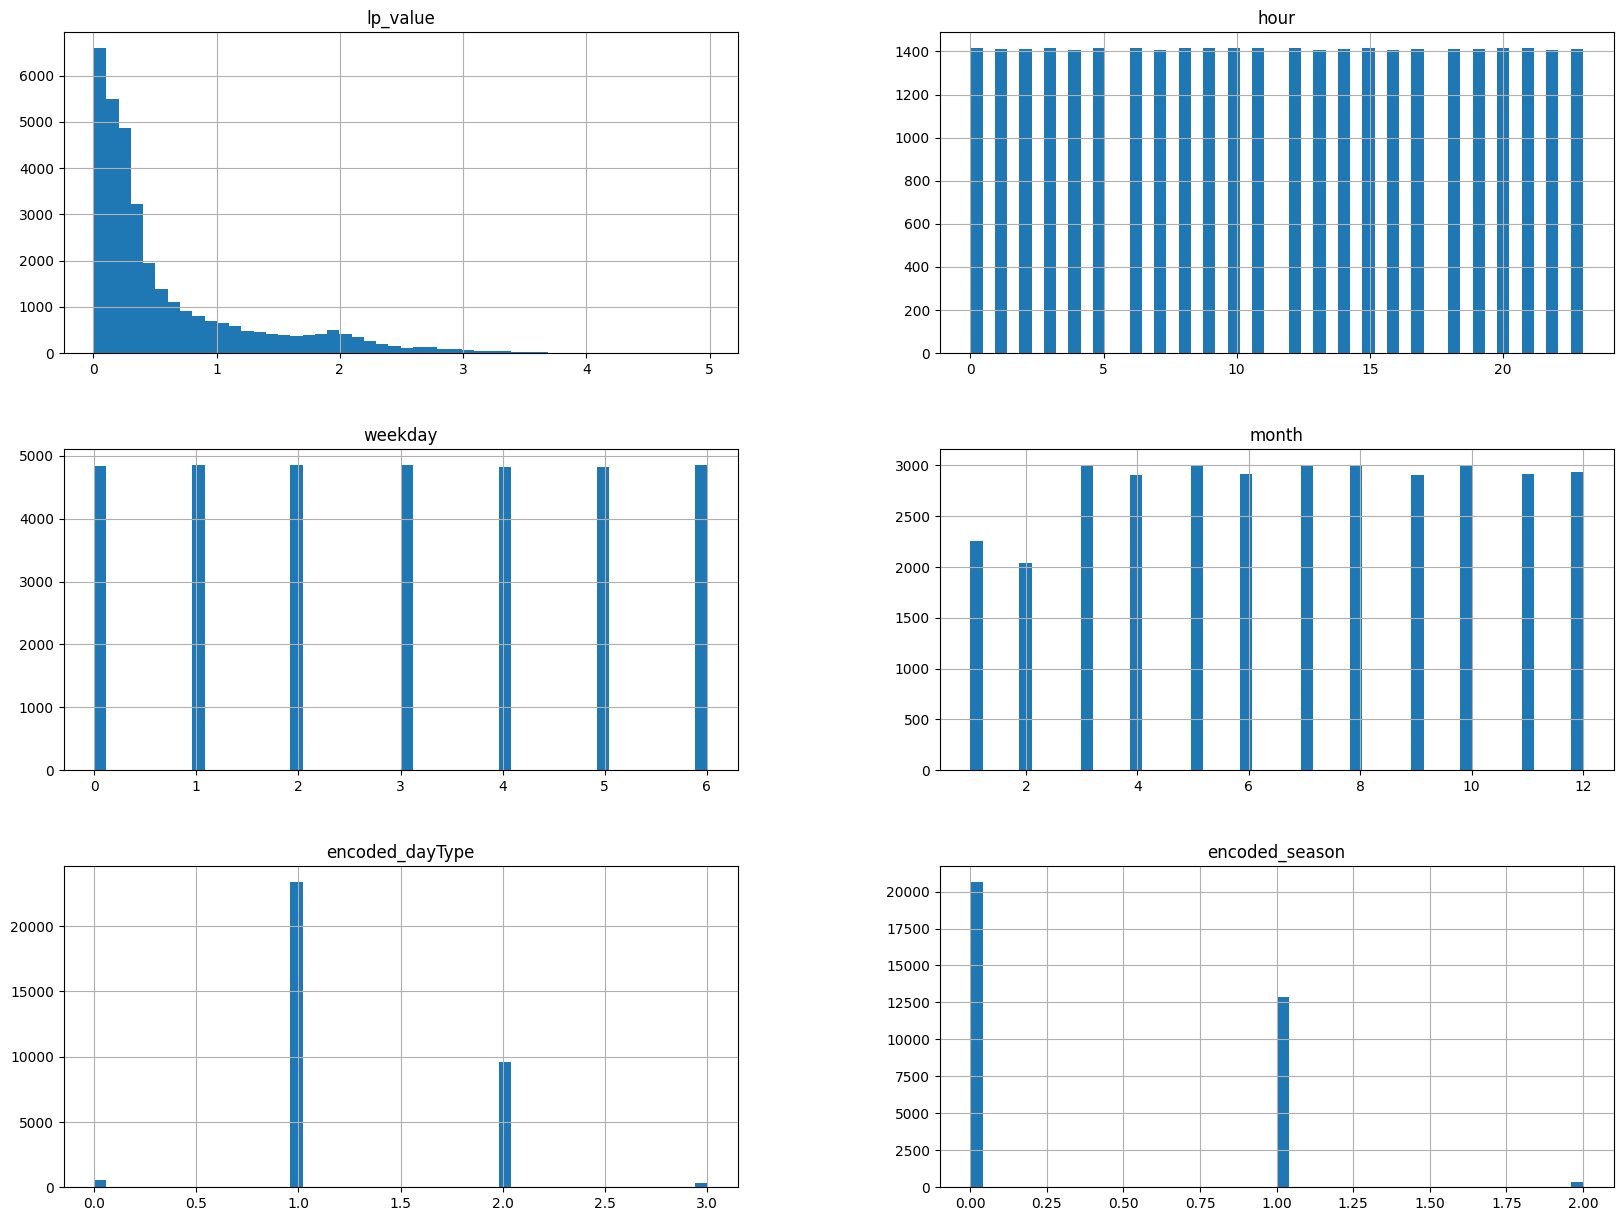

In [18]:
# Let's plot a histogram to get the feel of type of data we are dealing with
# We can plot histogram only for numerical attributres

%matplotlib inline
import matplotlib.pyplot as plt
historical_data.hist(bins=50, figsize=(20,15))
plt.show()

In [65]:
historical_data.head()

,lp_value,hour,weekday,month,encoded_dayType,encoded_season
0,1.818,23.0,5.0,2.0,1,1
1,0.289,0.0,6.0,3.0,2,1
2,2.229,1.0,6.0,3.0,2,1
3,0.109,2.0,6.0,3.0,1,1
4,0.256,3.0,6.0,3.0,1,1


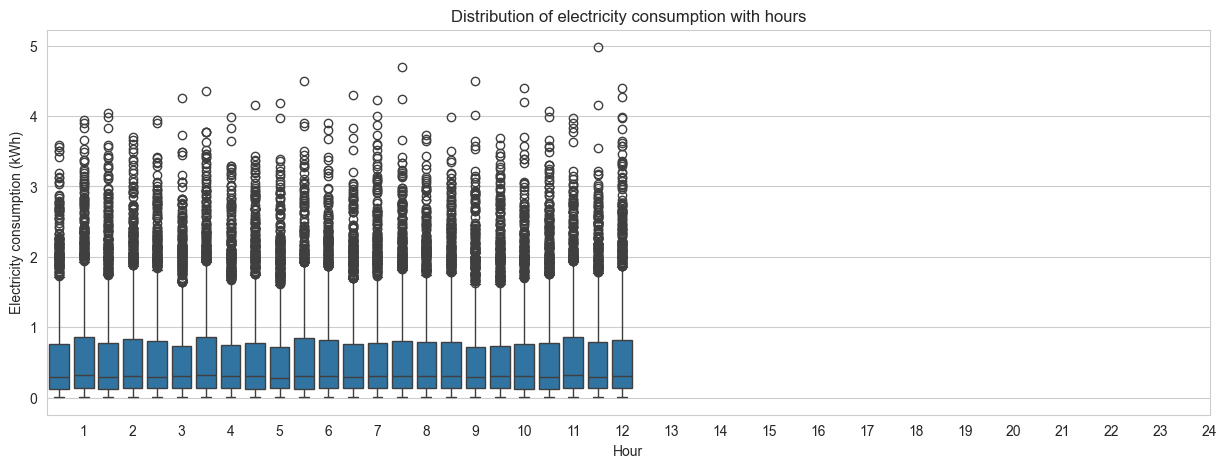

In [68]:
import seaborn as sns

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="hour", y="lp_value", data=historical_data)
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity consumption (kWh)")
ax.set_title("Distribution of electricity consumption with hours");

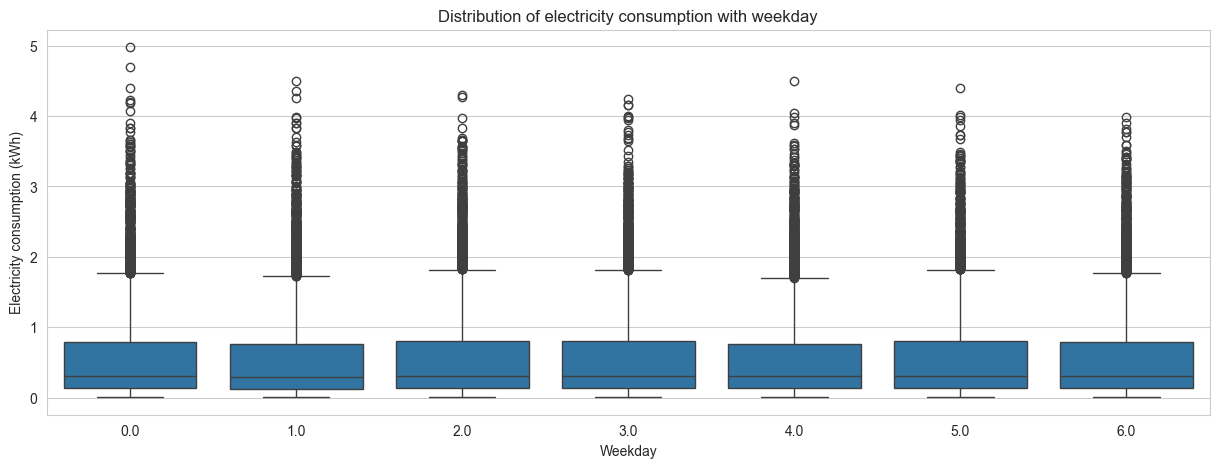

In [70]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="weekday", y="lp_value", data=historical_data)

ax.set_xlabel("Weekday")
ax.set_ylabel("Electricity consumption (kWh)")
ax.set_title("Distribution of electricity consumption with weekday");

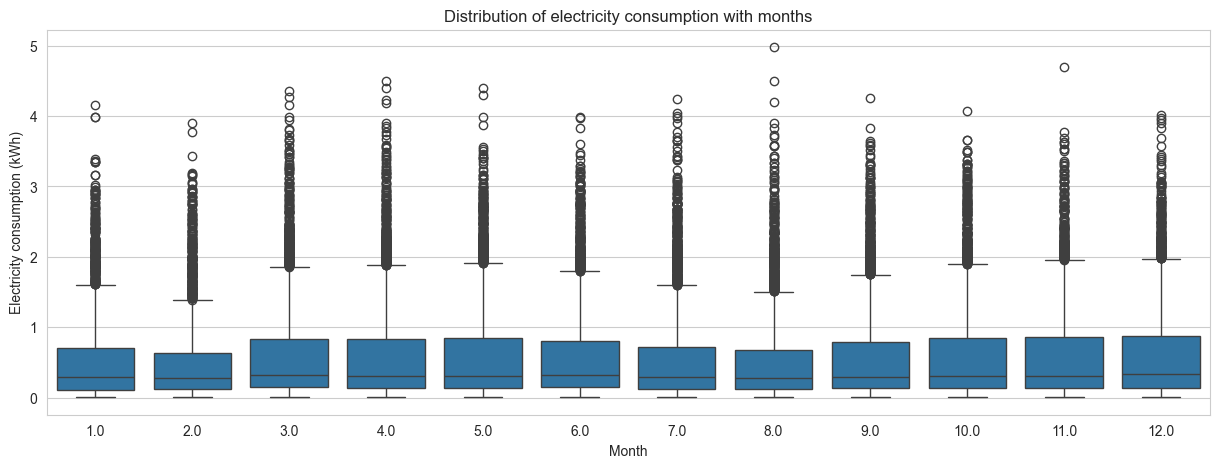

In [69]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x="month", y="lp_value", data=historical_data)

ax.set_xlabel("Month")
ax.set_ylabel("Electricity consumption (kWh)")
ax.set_title("Distribution of electricity consumption with months");

## Split dataset into test and training set

In [19]:
# To make this notebook's output identical at every run

import numpy as np

np.random.seed(42)

In [20]:
# With sklearn train_test_split

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(historical_data, test_size=0.2, random_state=42)

print ("Length of train set is", len(train_set))
print ("Length of test set is", len(test_set))


Length of train set is 27120
Length of test set is 6780


In [21]:
train_set.head()

,lp_value,hour,weekday,month,encoded_dayType,encoded_season
13069,0.108,1.0,6.0,8.0,1,0
2471,0.999,21.0,2.0,6.0,1,0
22596,0.132,1.0,0.0,9.0,1,1
6223,0.314,16.0,3.0,11.0,2,1
30463,0.184,14.0,2.0,8.0,2,0


In [93]:
#electric_usage = train_set.copy()
#electric_usage.head()

# Discover and visualize the data to gain insights

<Axes: xlabel='lp_value', ylabel='hour'>

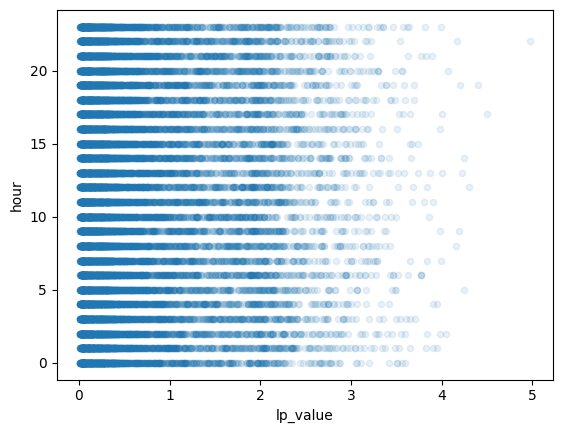

In [22]:
train_set.plot(kind="scatter", x="lp_value", y="hour", alpha=0.1)

In [23]:
train_set.describe()

,lp_value,hour,weekday,month,encoded_dayType,encoded_season
count,27120.000000,27120.000000,27120.000000,27120.000000,27120.000000,27120.000000
mean,0.598172,11.480125,2.998119,6.730494,1.285693,0.401512
std,0.697209,6.922025,2.002772,3.355940,0.506910,0.510263
min,0.007000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.133000,5.000000,1.000000,4.000000,1.000000,0.000000
50%,0.304000,11.000000,3.000000,7.000000,1.000000,0.000000
75%,0.781250,17.000000,5.000000,10.000000,2.000000,1.000000
max,4.978000,23.000000,6.000000,12.000000,3.000000,2.000000


# Prepare the data for Machine Learning algorithms

In [24]:
# Let’s revert to a clean training set

x = 0
for x in ['lp_value', ]:
    train_X = train_set.drop(x, axis=1) # drop label for training set
    train_Y = train_set[x].copy()

# Note drop() creates a copy of the data and does not affect train_set

In [25]:
train_X.head()

,hour,weekday,month,encoded_dayType,encoded_season
13069,1.0,6.0,8.0,1,0
2471,21.0,2.0,6.0,1,0
22596,1.0,0.0,9.0,1,1
6223,16.0,3.0,11.0,2,1
30463,14.0,2.0,8.0,2,0


In [26]:
train_Y.head()

13069    0.108
2471     0.999
22596    0.132
6223     0.314
30463    0.184
Name: lp_value, dtype: float64

## Feature scaling

In [30]:
# Let's use Scikit-Learn Imputer class to fill missing values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")

In [28]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [27]:
# Use Scikit-Learn minmax_scaling

from mlxtend.preprocessing import minmax_scaling
num_variables_min_max = []
for x in ['encoded_dayType','encoded_season','hour','weekday','month', ]:
    num_variables_min_max.append(x)
electric_usage_num_min_max = train_X[num_variables_min_max]
electric_usage_num_min_max.head()

,encoded_dayType,encoded_season,hour,weekday,month
13069,1,0,1.0,6.0,8.0
2471,1,0,21.0,2.0,6.0
22596,1,1,1.0,0.0,9.0
6223,2,1,16.0,3.0,11.0
30463,2,0,14.0,2.0,8.0


In [31]:
# Building a pipeline for preprocessing the numerical attributes for MinMaxScaler:

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
num_attribs_min_max = list(electric_usage_num_min_max)
num_pipeline_min_max = Pipeline([
    ('selector', DataFrameSelector(num_attribs_min_max)),
    ('imputer', SimpleImputer(strategy="mean")),
    ('min_max_scaler', MinMaxScaler()),
])


In [32]:
from sklearn.pipeline import FeatureUnion
full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline_min_max", num_pipeline_min_max),
])


In [33]:
train_X.head()

,hour,weekday,month,encoded_dayType,encoded_season
13069,1.0,6.0,8.0,1,0
2471,21.0,2.0,6.0,1,0
22596,1.0,0.0,9.0,1,1
6223,16.0,3.0,11.0,2,1
30463,14.0,2.0,8.0,2,0


In [34]:
train_X = full_pipeline.fit_transform(train_X)
print(train_X[0])
print(train_X[1])
print(train_X[2])

[0.33333333 0.         0.04347826 1.         0.63636364]
[0.33333333 0.         0.91304348 0.33333333 0.45454545]
[0.33333333 0.5        0.04347826 0.         0.72727273]


In [35]:
train_X.shape

(27120, 5)

# Select and train a model 

In [36]:
# Function to display scores of our alogorithms for cross-validation

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())


In [38]:
# Train a Linear Regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression()

In [39]:
result = lin_reg.predict(train_X[0:10])
result

array([0.55288843, 0.53672982, 0.62244365, 0.7233539 , 0.63545437,
       0.63042544, 0.5345618 , 0.54452168, 0.62718128, 0.64353474])

In [40]:
train_Y[0:10]

13069    0.108
2471     0.999
22596    0.132
6223     0.314
30463    0.184
22546    0.473
10941    0.165
30978    0.066
21901    0.501
15484    0.304
Name: lp_value, dtype: float64

In [41]:
# Calculate the RMSE in Linear Regression Model

from sklearn.metrics import mean_squared_error

electric_usage_predictions = lin_reg.predict(train_X)
lin_mse = mean_squared_error(train_Y, electric_usage_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(0.6945585423852872)

In [42]:
# K-fold Cross Validation for Linear Regression
from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, train_X, train_Y, scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.67968153 0.69009746 0.69721787 0.69110183 0.70395963 0.71045598
 0.68246297 0.68951046 0.7070406  0.69475736]
Mean: 0.6946285696825266
Standard deviation: 0.009638125635532397


In [43]:
# Train a model using Decision Tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_X, train_Y)

DecisionTreeRegressor(random_state=42)

In [44]:
# Calculate RMSE in Decision Tree model
from sklearn.metrics import mean_squared_error

electric_usage_predictions = tree_reg.predict(train_X)
tree_mse = mean_squared_error(train_Y, electric_usage_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.5732428296691472)

In [47]:
display_scores(tree_rmse)

Scores: 0.5732428296691472
Mean: 0.5732428296691472
Standard deviation: 0.0


In [45]:
# K-fold Cross Validation for Decision Tree Model
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
scores = cross_val_score(tree_reg, train_X, train_Y, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [46]:
display_scores(tree_rmse_scores)

Scores: [0.80958268 0.83603692 0.84027313 0.8351326  0.85273065 0.85989498
 0.82390539 0.84175226 0.84588893 0.8249458 ]
Mean: 0.8370143329698105
Standard deviation: 0.013988704858960217


In [48]:
# Train a model using Random Forests

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(train_X, train_Y)

RandomForestRegressor(random_state=42)

In [49]:
forest_reg.predict(train_X[0:10])

array([0.18184975, 0.51127507, 0.342757  , 0.56598824, 0.86575231,
       0.46740833, 0.79160892, 0.65590727, 0.49996295, 0.22243467])

In [50]:
train_Y[0:10]

13069    0.108
2471     0.999
22596    0.132
6223     0.314
30463    0.184
22546    0.473
10941    0.165
30978    0.066
21901    0.501
15484    0.304
Name: lp_value, dtype: float64

In [51]:
# Calculate RMSE in Random Forest model
from sklearn.metrics import mean_squared_error

electric_usage_predictions = forest_reg.predict(train_X)
forest_mse = mean_squared_error(train_Y, electric_usage_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(0.5813311970869808)

In [52]:
# Cross Validation in Random Forest model

from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, train_X, train_Y,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.75910453 0.78670215 0.79443904 0.77883924 0.79237792 0.80218766
 0.7748319  0.78051635 0.79096456 0.76985096]
Mean: 0.7829814313403849
Standard deviation: 0.012240054244522165


In [58]:
# Total attributes

attributes = num_attribs_min_max

## Fine-tune the Model

In [53]:
# GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [10, 30], 'max_features': [6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [20, 35], 'max_features': [7, 9]},
]

algo = RandomForestRegressor(random_state=42)
# train across 10 folds
grid_search = GridSearchCV(algo, param_grid, cv=10,
                           scoring='neg_mean_squared_error')
grid_search.fit(train_X, train_Y)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [6, 8], 'n_estimators': [10, 30]},
                         {'bootstrap': [False], 'max_features': [7, 9],
                          'n_estimators': [20, 35]}],
             scoring='neg_mean_squared_error')

In [54]:
# The best hyperparameter combinations

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [55]:
# Get the best estimator

grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

In [56]:
# Let's look at the score of each hyperparameter combination tested during the grid search

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.7919176197478767 {'max_features': 6, 'n_estimators': 10}
0.7853753103569597 {'max_features': 6, 'n_estimators': 30}
0.7919176197478767 {'max_features': 8, 'n_estimators': 10}
0.7853753103569597 {'max_features': 8, 'n_estimators': 30}
0.8362931981848986 {'bootstrap': False, 'max_features': 7, 'n_estimators': 20}
0.8362408289380108 {'bootstrap': False, 'max_features': 7, 'n_estimators': 35}
0.8362931981848986 {'bootstrap': False, 'max_features': 9, 'n_estimators': 20}
0.8362408289380108 {'bootstrap': False, 'max_features': 9, 'n_estimators': 35}


### Analyze the Best Models and Their Errors

In [59]:
# See the importance score of each attribute in GridSearchCV

feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.4075978401511421), 'hour'),
 (np.float64(0.2680966956348338), 'month'),
 (np.float64(0.2652389200527128), 'weekday'),
 (np.float64(0.037970829838486576), 'encoded_dayType'),
 (np.float64(0.021095714322824737), 'encoded_season')]

In [60]:
# Evaluate model on the Test Set

final_model = grid_search.best_estimator_

x = 0
for x in ['lp_value', ]:
    X_test = test_set.drop(x, axis=1)
    y_test = test_set[x].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [61]:
final_rmse

np.float64(0.7819157257868061)

In [64]:
y_test

27812    0.123
14594    0.048
5749     0.312
21112    0.121
1402     0.042
         ...  
24710    0.144
5545     1.172
15820    0.474
25671    0.051
26686    0.204
Name: lp_value, Length: 6780, dtype: float64

In [62]:
final_predictions

array([1.24555556, 0.69412104, 0.84920548, ..., 0.63335278, 0.48157222,
       0.76237941])

Congratulations! You already know quite a lot about Machine Learning. :)